In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [3]:
!pip install scikit-image

In [4]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from image_utils import *
import mappings as mapps

In [5]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date
from scipy.ndimage import label
import time
from tqdm import tqdm
import os

In [6]:
update_storage_access()

In [7]:
environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

#2022
#guyane 2022
path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

#martinique 2022
path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]
          
#guadeloupe 2022
path_s3_pleiades_data_2022_guadeloupe = environment["sources"]["PLEIADES"][2022]["guadeloupe"]
path_local_pleiades_data_2022_guadeloupe = environment["local-path"]["PLEIADES"][2022]["guadeloupe"]

#mayotte 2022
path_s3_pleiades_data_2022_mayotte = environment["sources"]["PLEIADES"][2022]["mayotte"]
path_local_pleiades_data_2022_mayotte = environment["local-path"]["PLEIADES"][2022]["mayotte"]

#2020
#mayotte 2020
path_s3_pleiades_data_2020_mayotte = environment["sources"]["PLEIADES"][2020]["mayotte"]
path_local_pleiades_data_2020_mayotte = environment["local-path"]["PLEIADES"][2020]["mayotte"]

#2019
#mayotte 2019
path_s3_pleiades_data_2019_mayotte = environment["sources"]["PLEIADES"][2019]["mayotte"]
path_local_pleiades_data_2019_mayotte = environment["local-path"]["PLEIADES"][2019]["mayotte"]

#2018
#reunion 2018
path_s3_pleiades_data_2018_reunion = environment["sources"]["PLEIADES"][2018]["reunion"]
path_local_pleiades_data_2018_reunion = environment["local-path"]["PLEIADES"][2018]["reunion"]

#2017
#martinique 2017
path_s3_pleiades_data_2017_martinique = environment["sources"]["PLEIADES"][2017]["martinique"]
path_local_pleiades_data_2017_martinique = environment["local-path"]["PLEIADES"][2017]["martinique"]

#mayotte 2017
path_s3_pleiades_data_2017_mayotte = environment["sources"]["PLEIADES"][2017]["mayotte"]
path_local_pleiades_data_2017_mayotte = environment["local-path"]["PLEIADES"][2017]["mayotte"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [8]:
# DL PLEIADE mayotte 2020
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2020_mayotte}",
        lpath=f"../{path_local_pleiades_data_2020_mayotte}",
        recursive=True)

In [11]:
# DL PLEIADE mayotte 2017
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_mayotte}",
        lpath=f"../{path_local_pleiades_data_2017_mayotte}",
        recursive=True)

## Détection nuages

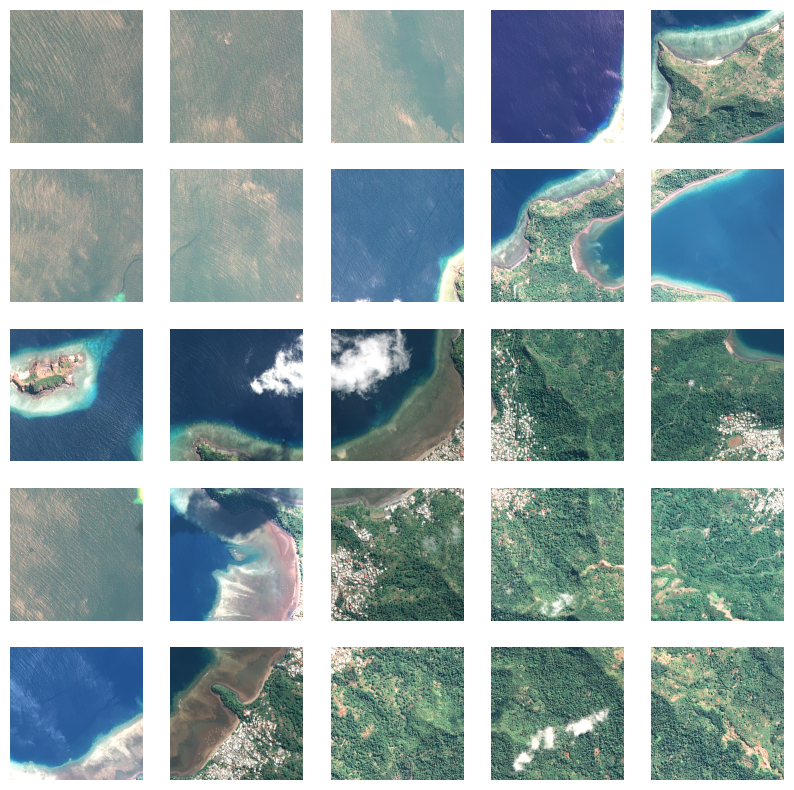

In [37]:
plot_square_images([0,1,2], 2 , None, '../data/PLEIADES/2020/MAYOTTE/ORT_2020052526656219_0508_8599_U38S_8Bits.jp2')

Voici un exemple d'une image avec un nuage

In [10]:
#image avec nuage 
filename_3 = '../data/PLEIADES/2020/MAYOTTE/ORT_2020052526656219_0508_8599_U38S_8Bits.jp2' 
date_3 = date.fromisoformat('2020-01-01')

In [12]:
image_3 = SatelliteImage.from_raster(
        filename_3,
        date = date_3, 
        n_bands = 3,
        dep = "976"
    )
image_3.normalize()

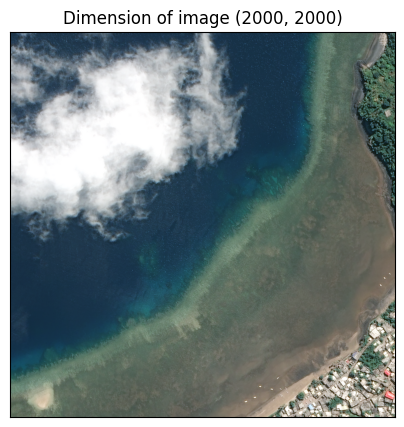

In [13]:
image_3.plot([0,1,2]) 

In [31]:
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import time

def count_patch_nuage(image):
    list_images = image.split(250)
    list_nuage = []
    num_patch = 0
    #on parcourt chaque patch
    for mini_image in list_images:
        image = mini_image.array.copy()

        image = image[[0,1,2],:, :]

        image = (image*255).astype(np.uint8)

        image = image.transpose(1, 2, 0)

        # Convertir l'image RGB en niveau de gris
        grayscale = np.mean(image, axis=2)

        # Trouver les amas de pixels blancs de taille 10 ou plus
        threshold = 250  # seuil pour considérer un pixel comme "blanc"

        labeled, num_features = label(grayscale > threshold)

        nuage=False
        min_size = 20000 # taille minimale de l'amas
        if num_features >= 1:
            lab = np.asarray(labeled)
            for i in range(1, num_features + 1):
                if np.sum(lab == i) >= min_size: 
                    nuage= True
                    break
        
        if nuage == True:
            list_nuage.append(num_patch)
        
        num_patch +=1
            
    return(list_nuage)
            
def plot_nuage(image):
    image = image.array.copy()

    image = image[[0,1,2],:, :]

    image = (image*255).astype(np.uint8)

    image = image.transpose(1, 2, 0)

    # Convertir l'image RGB en niveau de gris
    grayscale = np.mean(image, axis=2)

    # Trouver les amas de pixels blancs correspondant à 5% ou plus de l'image
    threshold = 250  # seuil pour considérer un pixel comme "blanc"

    labeled, num_features = label(grayscale > threshold)

    min_size = 20000  # taille minimale de l'amas (2000*2000 = 4 000 000 pixels et on souhaite détecter des nuages qui occupent + de 0,5% de l'image)
    mask = np.zeros_like(grayscale, dtype=bool)
    cpt = 0
    if num_features >= 1:
        lab = np.asarray(labeled)
        for i in tqdm(range(1, num_features + 1)): # Affichage de la barre de progression
            if np.sum(lab == i) >= min_size: 
                mask |= np.array(labeled == i)
                cpt +=1

    # Afficher l'image avec les amas de pixels blancs en rouge
    result = np.copy(image)
    result[mask] = [255, 0, 0]

    # Afficher l'image originale et l'image résultante côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.set_title("Image originale")
    ax2.imshow(result)
    ax2.set_title("Image avec les amas de pixels blancs en rouge")
    plt.show()
    return(cpt)
    
def detect_nuage(folder_path):
    nuages = []
    filenames = os.listdir(folder_path)[:300]
    
    for filename in tqdm(filenames): # Affichage de la barre de progression
        try :
        
            image = SatelliteImage.from_raster(
                    folder_path + '/' +filename,
                    date = date.fromisoformat('2020-01-01'), 
                    n_bands = 3,
                    dep = "976"
                    )
            image.normalize()

            list_images = image.split(250)

            #on parcourt chaque patch
            for mini_image in list_images:

                image = mini_image.array.copy()

                image = image[[0,1,2],:, :]

                image = (image*255).astype(np.uint8)

                image = image.transpose(1, 2, 0)

                # Convertir l'image RGB en niveau de gris
                grayscale = np.mean(image, axis=2)

                # Trouver les amas de pixels blancs de taille 10 ou plus
                threshold = 250  # seuil pour considérer un pixel comme "blanc"

                labeled, num_features = label(grayscale > threshold)

                nuage=False
                min_size = 20000 # taille minimale de l'amas (on souhaite détecter des nuages qui occupent + de 0,5% de l'image TOTALE !)
                if num_features >= 1:
                    lab = np.asarray(labeled)
                    for i in range(1, num_features + 1):
                        if np.sum(lab == i) >= min_size:
                            nuage= True
                            break
                        else:
                            continue

                if nuage == True:
                    nuages.append(folder_path + '/' +filename)
                    break
                    
                else :
                    continue

        except RasterioIOError:
            print("L'image "+filename+" ne s'ouvre pas.")
            
        finally :
            continue
            
    return(nuages)

def detect_nuage_list(list_path):
    nuages = []
    
    for filename in tqdm(list_path): # Affichage de la barre de progression
        try :
        
            image = SatelliteImage.from_raster(
                    filename,
                    date = date.fromisoformat('2020-01-01'), 
                    n_bands = 3,
                    dep = "976"
                    )
            image.normalize()

            image = image.array.copy()

            image = image[[0,1,2],:, :]

            image = (image*255).astype(np.uint8)

            image = image.transpose(1, 2, 0)

            # Convertir l'image RGB en niveau de gris
            grayscale = np.mean(image, axis=2)

            # Trouver les amas de pixels blancs de taille 10 ou plus
            threshold = 250  # seuil pour considérer un pixel comme "blanc"

            labeled, num_features = label(grayscale > threshold)

            nuage=False
            min_size = 20000 # taille minimale de l'amas (on souhaite détecter des nuages qui occupent + de 0,5% de l'image TOTALE !)
            if num_features >= 1:
                lab = np.asarray(labeled)
                for i in range(1, num_features + 1):
                    if np.sum(lab == i) >= min_size:
                        # cpt +=1
                        nuage= True
                        break
                    else:
                        continue

            if nuage == True:
                nuages.append(folder_path + '/' +filename)
                break

            else :
                continue

        except RasterioIOError:
            print("L'image "+filename+" ne s'ouvre pas.")
            
        finally :
            continue
            
    return(nuages)




In [26]:
nuages = detect_nuage_folder('../data/PLEIADES/2020/MAYOTTE')

100%|██████████| 300/300 [08:44<00:00,  1.75s/it]


In [27]:
len(nuages)

36

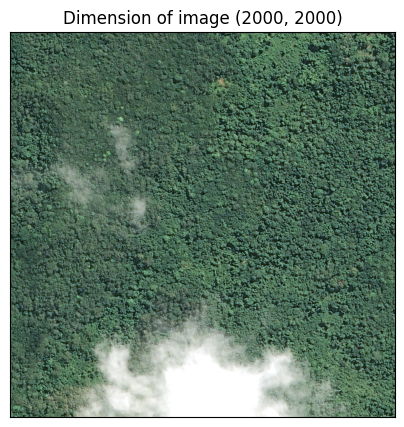

In [32]:
image_test = SatelliteImage.from_raster(
        nuages[20],
        date = date.fromisoformat('2020-01-01'), 
        n_bands = 3,
        dep = "976"
        )
image_test.normalize()
image_test.plot([0,1,2])
#plot_nuage(image_test)